## Lesson-07 Recurrent Neural Networks 循环神经网络的原理及应用

循环神经网络是我们常用的一个网络模型，这个网络能够处理例如字符串，时间序列等问题。因为模型对序列问题的优势，RNN模型已经成为了自然语言处理问题的常见方法。

在本课程的作业中，我们将完成三个任务：

0. 基于任务驱动，实际感受并能够初步使用pytorch；
1. 使用RNN模型进行名字的国籍分类；(这个程序主要是参考的Pytorch文档)

RNN也可以用于金融数据的预测，例如:
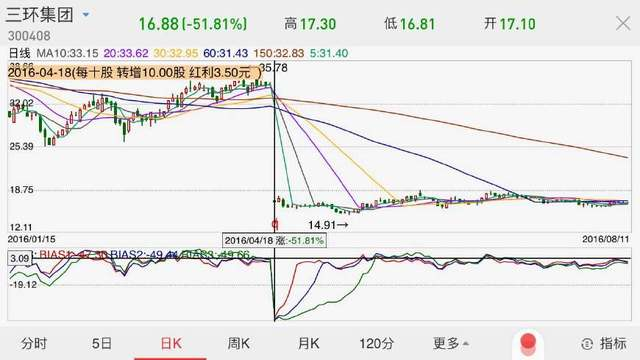

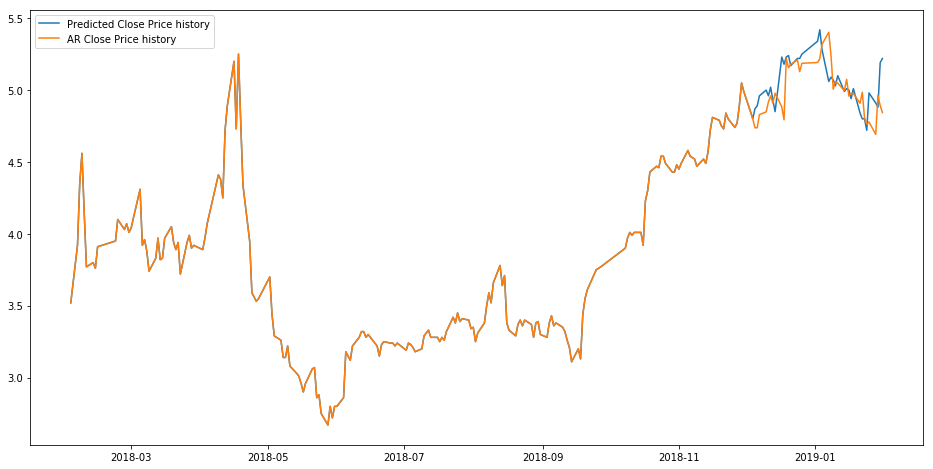

上图中蓝色的部分就是预测值， 关于RNN模型对金融数据的预测，我们只会会增加专门的研讨课程，给大家讲解

我们今天带给大家的是使用RNN进行名字的国籍分类:

## 1. 使用RNN模型进行名字的国籍分类

首先，我们下载数据: 将这个数据置于和我们jupyter notebook位置相同的地方

#### 1.1 我们利用通配符，打印出所有的文件

In [111]:
from io import open
import glob
import os
import matplotlib.pyplot as plt


def find_files(path): return glob.glob(path)

print(find_files('data/names/*.txt'))

['data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Dutch.txt', 'data/names/English.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Irish.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Korean.txt', 'data/names/Polish.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt']


### 1.2 名字里边包含不少非Ascii码，为了简便问题，我们将他们转化为Ascii码

In [112]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_2_Ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_2_Ascii('Ślusàrski'))

Slusarski


### Step1.3 然后我们建立类别和对于的名字的dictionary对应

In [113]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_2_Ascii(line) for line in lines]

for filename in find_files('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [114]:
n_categories

18

In [115]:
category_lines['Chinese'][:10]

['Ang', 'AuYong', 'Bai', 'Ban', 'Bao', 'Bei', 'Bian', 'Bui', 'Cai', 'Cao']

### 1.4 这一次我们使用pytorch, 来进行向量化

In [116]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

print(letter_to_index('J'))

print(line_to_tensor('Jones').size())

35
torch.Size([5, 1, 57])


In [117]:
line_to_tensor('Jones')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

我们可以看到，是对名字里的每个字符做了 one-hot操作

### 1.5 然后，我们构建一个这样的RNN网络

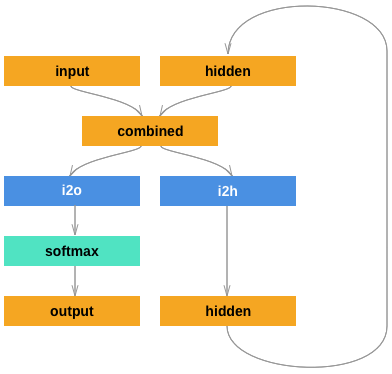

In [118]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

In [119]:
rnn = RNN(n_letters, n_hidden, n_categories)

### 1.6 运行一步RNN

为了运行这个rnn网络，我们需要给他一个input，然后再加上一个hidden state. 然后我们就能过获得一个output，这个output便是的是这个单词的属于每个国家的概率，和接下来的hidden state.

In [120]:
input = letter_to_tensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [121]:
output

tensor([[-2.8540, -2.9588, -2.8867, -2.8497, -2.9618, -2.8092, -2.9674, -2.8693,
         -2.8517, -2.8625, -2.9264, -2.9031, -2.8311, -2.9206, -2.8702, -2.9703,
         -2.9110, -2.8444]], grad_fn=<LogSoftmaxBackward>)

In [122]:
next_hidden

tensor([[ 0.0142, -0.0587, -0.0332, -0.0456,  0.0899, -0.1216,  0.1325,  0.0766,
          0.0218,  0.0417,  0.0279, -0.0291,  0.0820, -0.0816,  0.0482,  0.0055,
         -0.0712, -0.0651, -0.0179, -0.0360, -0.0689,  0.0212,  0.0485,  0.0457,
         -0.0940,  0.0217, -0.0133, -0.0295, -0.0865,  0.0540,  0.0363, -0.0192,
          0.0498, -0.0323, -0.0593, -0.0045,  0.0910, -0.0156,  0.0646,  0.0049,
         -0.0062, -0.0768, -0.0802,  0.0278, -0.0691, -0.1273,  0.0175,  0.0115,
         -0.1049,  0.0998, -0.0531, -0.0700,  0.0281, -0.0992, -0.0624,  0.0385,
          0.0754,  0.1061,  0.0256, -0.0478, -0.0264, -0.0524,  0.0457, -0.0012,
          0.1061, -0.0149,  0.0708, -0.1217,  0.0542, -0.0574,  0.1081, -0.0083,
          0.0633, -0.0374, -0.0813,  0.0194, -0.0941,  0.0393, -0.0329,  0.0834,
          0.0382,  0.0042, -0.0075,  0.1269,  0.0359, -0.1193, -0.0769, -0.0051,
         -0.0319, -0.0081, -0.0241,  0.1264, -0.0368,  0.1407, -0.0169,  0.0761,
          0.0083, -0.0173,  

然后，我们可以使用 line_to_tensor, 把一句话直接变成 tensor

In [123]:
input = line_to_tensor('Albert')
hidden = torch.zeros(1, n_hidden)
print(input[0])
output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
tensor([[-2.8540, -2.9588, -2.8867, -2.8497, -2.9618, -2.8092, -2.9674, -2.8693,
         -2.8517, -2.8625, -2.9264, -2.9031, -2.8311, -2.9206, -2.8702, -2.9703,
         -2.9110, -2.8444]], grad_fn=<LogSoftmaxBackward>)


这个output，就是基于目前的RNN参数，预测出来的国籍概率分布。显然是不对的，因为里边的参数都是随机的。

### 1.7 更好的观察结果

为了能够更好的看到我们的训练结果，我们需要把输出的tensor变成我们能看懂的国籍

In [124]:
def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

对于刚刚产生的output，我们使用这个函数

In [125]:
print(category_from_output(output))

('French', 5)


### 1.8 随机生成训练数据

In [126]:
import random

def sample(l):
    return l[random.randint(0, len(l) - 1)]

def sample_trainning():
    category = sample(all_categories)
    line = sample(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = sample_trainning()
    print('category =', category, '/ line =', line)

category = Irish / line = O'Neal
category = Russian / line = Halymbadja
category = Russian / line = Gatovsky
category = English / line = Uttley
category = Dutch / line = Raske
category = Chinese / line = Yang
category = Spanish / line = Gonzales
category = Spanish / line = Marti
category = Italian / line = Gronchi
category = English / line = Munro


### 因为我们这个模型需要 softmax 来获得每个类别，所以我们使用cross-entropy作为Loss函数

In [127]:
criterion = nn.CrossEntropyLoss()

In [128]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [129]:
import time
import math

n_iters = 100000 # 这个数字你可以调大一些
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 11s) 2.5248 Yao / Chinese ✓
10000 10% (0m 24s) 1.3057 Sui / Korean ✗ (Chinese)
15000 15% (0m 36s) 1.2693 Rallis / Greek ✓
20000 20% (0m 47s) 4.5038 Hughes / Vietnamese ✗ (Scottish)
25000 25% (0m 59s) 1.4241 Pereira / Portuguese ✓
30000 30% (1m 10s) 1.8420 Sai / Chinese ✗ (Vietnamese)
35000 35% (1m 21s) 2.1197 Dinko / Polish ✗ (Czech)
40000 40% (1m 33s) 0.7393 Si / Korean ✓
45000 45% (1m 45s) 1.3891 Fabre / French ✓
50000 50% (1m 58s) 0.2737 Rohmanov / Russian ✓
55000 55% (2m 9s) 1.1549 Gomulka / Czech ✗ (Polish)
60000 60% (2m 20s) 0.0878 Viskov / Russian ✓
65000 65% (2m 34s) 3.2235 Simon / English ✗ (French)
70000 70% (2m 46s) 1.1972 Benitez / Spanish ✓
75000 75% (2m 59s) 0.2682 Abashev / Russian ✓
80000 80% (3m 12s) 1.0729 Piccirillo / Spanish ✗ (Italian)
85000 85% (3m 25s) 1.5716 Cabral / Portuguese ✓
90000 90% (3m 38s) 1.8082 Jimenez / Polish ✗ (Spanish)
95000 95% (3m 51s) 1.0249 Stramba / Czech ✓
100000 100% (4m 2s) 0.1251 Inokuma / Japanese ✓


### 1.9 观察Loss的变化

In [130]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [131]:
# all_losses

In [132]:
%matplotlib inline

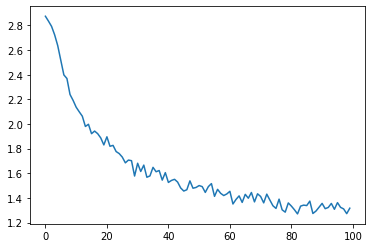

In [133]:
plt.plot(all_losses)

In [134]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.60) Russian
(-1.22) Czech
(-2.99) Irish

> Jackson
(-0.13) Scottish
(-2.71) English
(-3.72) Russian

> Satoshi
(-0.87) Japanese
(-1.53) Arabic
(-1.85) Polish


In [135]:
for i in range(3):
    category, line, category_tensor, line_tensor = sample_trainning()
    print('category =', category, '/ line =', line)
    predict(line)

category = Vietnamese / line = Pham

> Pham
(-0.14) Vietnamese
(-2.84) Chinese
(-3.78) Arabic
category = Russian / line = Likhovtsev

> Likhovtsev
(-0.01) Russian
(-5.96) French
(-6.09) Czech
category = English / line = Luttrell

> Luttrell
(-1.71) German
(-1.73) Spanish
(-1.83) French


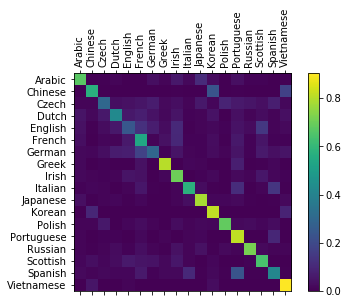

In [136]:
import matplotlib.ticker as ticker
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = sample_trainning()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1        # 横向为实际值，纵向为预测值
    
for i in range(n_categories):
    confusion[i]/=(confusion[i].sum())
    
fig = plt.figure()

ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels(['']+all_categories,rotation=90)
ax.set_yticklabels(['']+all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

1.识别越南语、希腊语、韩语的效果较好；
2.英语和苏格兰语、爱尔兰语区分区分效果较差；
3.优秀的荷兰语。

## 代码练习

定义待会儿要调用的方法

In [106]:
# 训练一行
def train_a_line(model, category_tensor, line_tensor, criterion = nn.CrossEntropyLoss()):
    hidden = model.initHidden()

    model.zero_grad()        # 将网络梯度清零
    
    '''
    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden) # 输入为二维，手动forward
    '''
    
    output, hidden = model(line_tensor, hidden)        # 输入为三维，lstm和gru调用forward
    
    loss = criterion(output, category_tensor)
    loss.backward()        # 将结果反馈给整个网络

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in model.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [28]:
# 训练并记录用时
def make_history(model, n_iters = 100000, pr_freq = 5000, pl_freq = 1000, criterion = nn.CrossEntropyLoss()):
    print(model)
    
    all_losses = []
    time_spent = []
    
    current_loss = 0
    start = time.time()
    
    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = sample_trainning()
        output, loss = train_a_line(model, category_tensor, line_tensor, criterion)
        current_loss += loss

        if iter % pr_freq == 0:
            guess, guess_i = category_from_output(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % pl_freq == 0:
            all_losses.append(current_loss / plot_every)
            time_spent.append(time.time() - start)
            current_loss = 0
            
    return all_losses, time_spent

In [42]:
# 作图便于观察结果
def evaluate2(model, line_tensor):
    hidden = model.initHidden()
    '''
    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)
    '''
    
    output, hidden = model(line_tensor, hidden)        # 调用forward

    return output

def plot_matrix(model, n_confusion = 10000):
    confusion = torch.zeros(n_categories, n_categories)

    for i in range(n_confusion):
        category, line, category_tensor, line_tensor = sample_trainning()
        output = evaluate2(model, line_tensor)
        guess, guess_i = category_from_output(output)
        category_i = all_categories.index(category)
        confusion[category_i][guess_i]+=1

    for i in range(n_categories):
        confusion[i]/=(confusion[i].sum())

    fig = plt.figure()

    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax)

    ax.set_xticklabels(['']+all_categories,rotation=90)
    ax.set_yticklabels(['']+all_categories)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

### 1. 尝试在我们的RNN模型中添加更多layers，然后观察Loss变化

1.RNN_Senior：在单层RNN中设置三个隐藏层，但是隐藏层数增加后收敛速度变慢了，分类效果也没有变好。

In [31]:
class RNN_Senior(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_Senior, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Sequential(
            nn.Linear(input_size + hidden_size, hidden_size), 
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            )
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
rnn_s = RNN_Senior(n_letters, n_hidden, n_categories)
losses1, t1 = make_history(rnn_s)        # 输入为二维
# plot_matrix(rnn_s)

RNN_Senior(
  (i2h): Sequential(
    (0): Linear(in_features=185, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax()
)
5000 5% (0m 19s) 2.8327 Quraishi / Italian ✗ (Arabic)
10000 10% (0m 39s) 2.7629 Neusser / German ✗ (Czech)
15000 15% (0m 58s) 2.3085 Itami / Italian ✗ (Japanese)
20000 20% (1m 17s) 1.6377 Shuo / Korean ✗ (Chinese)
25000 25% (1m 36s) 1.0230 Zhan / Chinese ✓
30000 30% (1m 55s) 2.9539 Laing / Chinese ✗ (English)
35000 35% (2m 15s) 2.1784 Barros / Greek ✗ (Portuguese)
40000 40% (2m 35s) 1.3670 Ybarra / Spanish ✓
45000 45% (2m 54s) 1.3185 Mendoza / Spanish ✓
50000 50% (3m 13s) 2.0874 Shackleton / Scottish ✗ (English)
55000 55% (3m 32s) 2.8213 Adam / Arabic ✗ (English)
60000 60% (3m 51s) 0.2524 Stamatelos / Greek ✓
65000 65% (4m 11s) 0.8644 Spano / Italian ✓
70000 70% (4m 30s) 1.7765 R

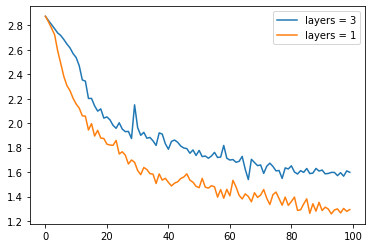

In [89]:
plt.plot(losses1, label = 'layers = 3')
plt.plot(all_losses, label = 'layers = 1')
plt.legend()

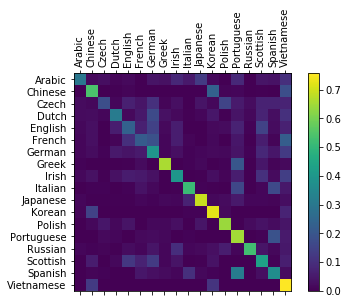

In [34]:
plot_matrix(rnn_s)

### 2. 将原始的RNN模型改成nn.LSTM和nn.GRU， 并且改变 `n_iters = 1000 ` 这个值，观察其变化

2.LSTM：单层LSTM的收敛速度和分类效果也不如单层RNN，对希腊语对分类效果变好

In [37]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.i2h = nn.LSTM(input_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.i2h(input, hidden)
        output = self.i2o(output[-1])
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        h0 = torch.zeros(1, 1, self.hidden_size)
        c0 = torch.zeros(1, 1, self.hidden_size)
        return h0, c0
    
lstm = LSTM(n_letters, n_hidden, n_categories)
losses2, t2 = make_history(lstm)
# plot_matrix(lstm)

LSTM(
  (i2h): LSTM(57, 128)
  (i2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax()
)
5000 5% (0m 20s) 2.7616 Ding / Chinese ✓
10000 10% (0m 41s) 3.0241 Taniguchi / Polish ✗ (Japanese)
15000 15% (1m 1s) 2.8922 Meadows / Greek ✗ (English)
20000 20% (1m 21s) 2.9458 Klimes / Greek ✗ (Czech)
25000 25% (1m 41s) 2.7812 Fernandes / Greek ✗ (Portuguese)
30000 30% (2m 2s) 2.6867 O'Neill / Czech ✗ (Irish)
35000 35% (2m 22s) 2.0399 Rivera / Spanish ✓
40000 40% (2m 42s) 2.3032 Kolbe / French ✗ (German)
45000 45% (3m 3s) 0.7014 Yagodinsky / Russian ✓
50000 50% (3m 23s) 2.0004 Swanson / Scottish ✗ (English)
55000 55% (3m 43s) 2.5753 Viola / Japanese ✗ (Italian)
60000 60% (4m 3s) 1.4595 Do / Korean ✗ (Vietnamese)
65000 65% (4m 23s) 1.9665 Cole / English ✓
70000 70% (4m 44s) 2.3988 Davie / French ✗ (English)
75000 75% (5m 4s) 1.0967 Chin / Chinese ✗ (Korean)
80000 80% (5m 24s) 4.1240 Nave / Vietnamese ✗ (Italian)
85000 85% (5m 44s) 1.6126 Lee / Chinese ✗ (Korean)
90000 

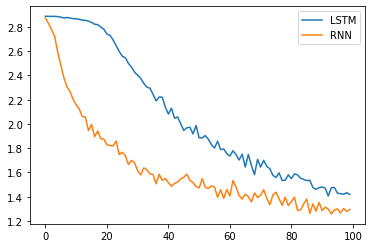

In [90]:
plt.plot(losses2, label = 'LSTM')
plt.plot(all_losses, label = 'RNN')
plt.legend()

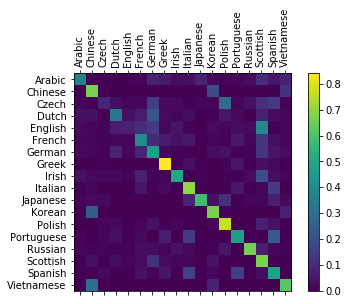

In [43]:
plot_matrix(lstm)

3.GRU：单层GRU收敛速度也不如单层RNN，但是比之前两个要好一些，也是对希腊语对分类效果变好

In [62]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.i2h = nn.GRU(input_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.i2h(input, hidden)
        output = self.i2o(output[-1, :, :])
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        h0 = torch.zeros(1, 1, self.hidden_size)
        return h0

gru = GRU(n_letters, n_hidden, n_categories)
losses3, t3 = make_history(gru)
# plot_matrix(gru)    

GRU(
  (i2h): GRU(57, 128)
  (i2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax()
)
5000 5% (0m 23s) 2.6263 Najjar / Arabic ✓
10000 10% (0m 43s) 2.7673 Duggan / Spanish ✗ (English)
15000 15% (1m 3s) 2.4884 Kikkert / French ✗ (Dutch)
20000 20% (1m 23s) 3.3109 Holguin / Scottish ✗ (Spanish)
25000 25% (1m 44s) 3.0510 Kozlow / Czech ✗ (Polish)
30000 30% (2m 4s) 4.0792 Loris / Greek ✗ (German)
35000 35% (2m 25s) 2.4924 Lohin / Scottish ✗ (Russian)
40000 40% (2m 45s) 3.0218 Harman / Irish ✗ (French)
45000 45% (3m 7s) 2.1778 Watt / French ✗ (Scottish)
50000 50% (3m 27s) 0.9238 Kringos / Greek ✓
55000 55% (3m 48s) 1.6106 Sneddon / Scottish ✗ (English)
60000 60% (4m 10s) 1.5517 Okabe / Japanese ✓
65000 65% (4m 31s) 2.2622 Santiago / Japanese ✗ (Spanish)
70000 70% (4m 52s) 1.7601 Thean / Vietnamese ✗ (Chinese)
75000 75% (5m 13s) 1.3926 Kattan / Arabic ✓
80000 80% (5m 34s) 0.4492 Nakanoi / Japanese ✓
85000 85% (5m 55s) 1.2949 Traverse / French ✓
90000 90% (6m 15s) 

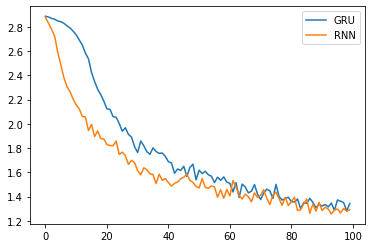

In [92]:
plt.plot(losses3, label = 'GRU')
plt.plot(all_losses, label = 'RNN')
plt.legend()

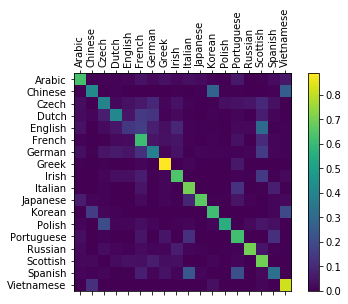

In [63]:
plot_matrix(gru)

改变iters

LSTM(
  (i2h): LSTM(57, 128)
  (i2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax()
)
1000 100% (0m 4s) 2.2976 Quinones / Dutch ✗ (Spanish)
LSTM(
  (i2h): LSTM(57, 128)
  (i2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax()
)
3000 100% (0m 12s) 0.1827 Roijackers / Dutch ✓


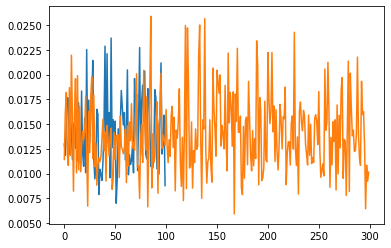

In [94]:
lo1, lt1 = make_history(lstm, n_iters = 1000, pr_freq = 1000, pl_freq = 10)
lo2, lt2 = make_history(lstm, n_iters = 3000, pr_freq = 3000, pl_freq = 10)
plt.plot(lo1)
plt.plot(lo2)

### 3. 把该RNN模型变成多层RNN模型，观察Loss的变化

4.LSTM_Senior：多层LSTM，收敛速度不忍直视，而且好像还降不下去了

In [64]:
class LSTM_Senior(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM_Senior, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.i2h = nn.LSTM(input_size, hidden_size, num_layers)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.i2h(input, hidden)
        output = self.i2o(output[-1, :, :])
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        h0 = torch.zeros(self.num_layers, 1, self.hidden_size)
        c0 = torch.zeros(self.num_layers, 1, self.hidden_size)
        return h0, c0

n_layers = 3
lstm_s = LSTM_Senior(n_letters, n_hidden, n_categories, n_layers)
losses4, t4 = make_history(lstm_s)
# plot_matrix(lstm_s)    

LSTM_Senior(
  (i2h): LSTM(57, 128, num_layers=3)
  (i2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax()
)
5000 5% (0m 59s) 2.8457 Gordon / Portuguese ✗ (Scottish)
10000 10% (1m 55s) 2.8709 Coghlan / Japanese ✗ (Irish)
15000 15% (2m 55s) 2.9786 Millar / Russian ✗ (Scottish)
20000 20% (3m 51s) 2.6280 Eventov / Russian ✓
25000 25% (4m 48s) 3.1481 Lobo / Chinese ✗ (Portuguese)
30000 30% (5m 42s) 2.8664 Schuler / French ✗ (German)
35000 35% (6m 37s) 2.8191 Grzeskiewicz / Greek ✗ (Polish)
40000 40% (7m 32s) 2.9400 Jagoda / English ✗ (Polish)
45000 45% (8m 26s) 2.9029 Mertens / Polish ✗ (Dutch)
50000 50% (9m 21s) 1.6611 Mach / Vietnamese ✓
55000 55% (10m 16s) 2.2772 Krakowski / Greek ✗ (Polish)
60000 60% (11m 12s) 2.8732 Emile / Arabic ✗ (French)
65000 65% (12m 7s) 2.9346 Sniders / Arabic ✗ (Dutch)
70000 70% (13m 2s) 2.8439 Gniewek / Arabic ✗ (Polish)
75000 75% (13m 57s) 3.2964 Manus / Chinese ✗ (Irish)
80000 80% (14m 51s) 2.6524 Onoda / Arabic ✗ (Japanese)
85

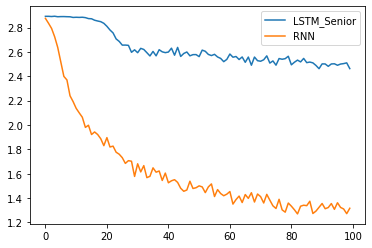

In [137]:
plt.plot(losses4, label = 'LSTM_Senior')
plt.plot(all_losses, label = 'RNN')
plt.legend()

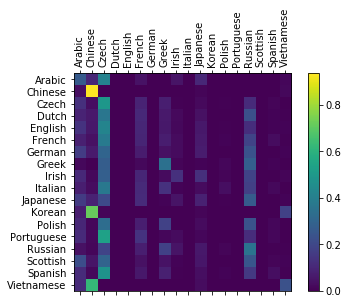

In [66]:
plot_matrix(lstm_s)

5. RNN_Senior2：三层RNN，效果最好的应该就是它了，但是不知道为啥

In [138]:
class RNN_Senior2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNN_Senior2, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.i2h = nn.RNN(input_size, hidden_size, num_layers)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.i2h(input, hidden)
        output = self.i2o(output[-1, :, :])
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size)

n_layers = 3
rnn_s2 = RNN_Senior2(n_letters, n_hidden, n_categories, n_layers)
losses5, t5 = make_history(rnn_s2)
# plot_matrix(lstm_s)    

RNN_Senior2(
  (i2h): RNN(57, 128, num_layers=3)
  (i2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax()
)
5000 5% (0m 27s) 2.6080 Kowalczyk / Greek ✗ (Polish)
10000 10% (0m 56s) 2.0719 Linville / German ✗ (French)
15000 15% (1m 22s) 1.5960 Russell / French ✗ (Scottish)
20000 20% (1m 50s) 3.3759 Kerner / German ✗ (Czech)
25000 25% (2m 17s) 1.1126 Senft / German ✓
30000 30% (2m 44s) 0.8213 Gorman / Irish ✓
35000 35% (3m 13s) 1.3589 Chu / Korean ✗ (Vietnamese)
40000 40% (3m 40s) 0.0900 Gwang  / Korean ✓
45000 45% (4m 6s) 0.6043 Escarcega / Spanish ✓
50000 50% (4m 33s) 0.5647 Said / Arabic ✓
55000 55% (5m 1s) 0.1903 D'cruze / Portuguese ✓
60000 60% (5m 27s) 6.1776 De santis / Greek ✗ (Italian)
65000 65% (5m 54s) 3.5485 John / Korean ✗ (Irish)
70000 70% (6m 21s) 1.4161 Sanchez / Czech ✗ (Spanish)
75000 75% (6m 49s) 0.0187 Bei / Chinese ✓
80000 80% (7m 16s) 0.1004 Cantu / Italian ✓
85000 85% (7m 41s) 3.0877 Banderas / Greek ✗ (Spanish)
90000 90% (8m 7s) 0.0911

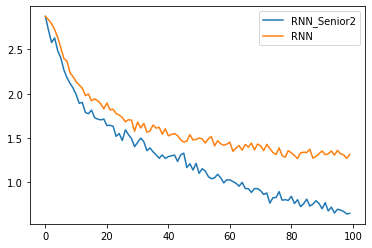

In [142]:
plt.plot(losses5, label = 'RNN_Senior2')
plt.plot(all_losses, label = 'RNN')
plt.legend()

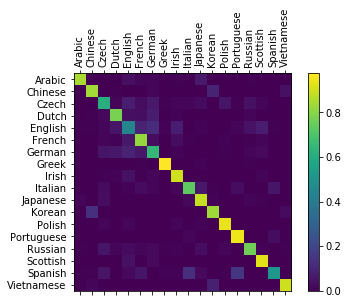

In [140]:
plot_matrix(rnn_s2)    

6.GRU_Senior：三层GRU

In [156]:
class GRU_Senior(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRU_Senior, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.i2h = nn.GRU(input_size, hidden_size, num_layers)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.i2h(input, hidden)
        output = self.i2o(output[-1, :, :])
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        h0 = torch.zeros(self.num_layers, 1, self.hidden_size)
        return h0

n_layears = 3
gru_s = GRU_Senior(n_letters, n_hidden, n_categories,n_layears )
losses6, t6 = make_history(gru_s)

GRU_Senior(
  (i2h): GRU(57, 128, num_layers=3)
  (i2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax()
)
5000 5% (0m 53s) 2.7417 Robert / French ✓
10000 10% (1m 46s) 2.8379 Schlusser / Polish ✗ (German)
15000 15% (2m 40s) 3.0435 Mohan / Arabic ✗ (Irish)
20000 20% (3m 34s) 2.6132 Martelli / Russian ✗ (Italian)
25000 25% (4m 27s) 1.4798 Zhou / Vietnamese ✗ (Chinese)
30000 30% (5m 20s) 2.8361 Mclean / Dutch ✗ (Scottish)
35000 35% (6m 13s) 1.2969 Doan / Vietnamese ✓
40000 40% (7m 6s) 2.1541 Ferro / Spanish ✗ (Portuguese)
45000 45% (7m 59s) 0.9921 Stamatelos / Greek ✓
50000 50% (9m 0s) 2.7821 Tunison / Russian ✗ (Dutch)
55000 55% (10m 1s) 1.3203 Demakis / Polish ✗ (Greek)
60000 60% (10m 59s) 0.2051 Sardelis / Greek ✓
65000 65% (11m 57s) 1.8048 Babutski / Polish ✗ (Russian)
70000 70% (12m 57s) 0.8017 Yeon / Korean ✓
75000 75% (13m 56s) 0.4332 Cho / Korean ✓
80000 80% (14m 56s) 1.1168 Marie / French ✓
85000 85% (15m 56s) 1.6355 Marquez / Portuguese ✗ (Spanish)


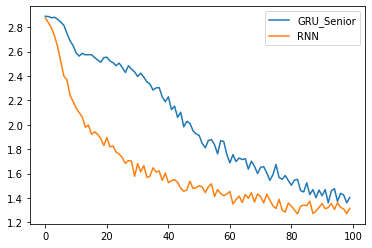

In [157]:
plt.plot(losses6, label = 'GRU_Senior')
plt.plot(all_losses, label = 'RNN')
plt.legend()

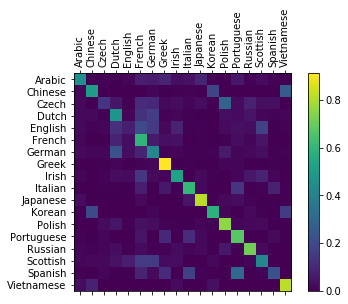

In [158]:
plot_matrix(gru_s)    

刚才的六个模型都分别和单层RNN对比了一下，现在这六个模型之间对比一下。
1.三层LSTM训练时间最长，但loss基本没有发生变化；
2.三层RNN收敛速度最快，训练时间也比较适中；
3.增加了隐藏层的RNN前期收敛较快，但之后loss下降不明显；
4.三层GRU和LSTM收敛速度反而比单层要慢。

Text(0.5, 1.0, 'Run Time')

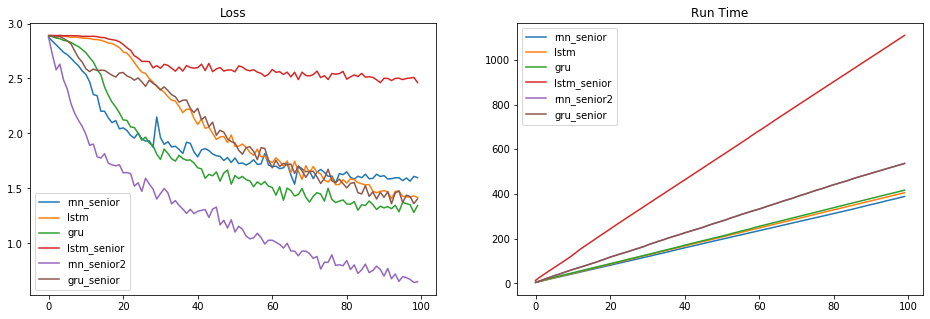

In [161]:
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(losses1, label = 'rnn_senior')
plt.plot(losses2, label = 'lstm')
plt.plot(losses3, label = 'gru')
plt.plot(losses4, label = 'lstm_senior')
plt.plot(losses5, label = 'rnn_senior2')
plt.plot(losses6, label = 'gru_senior')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(t1, label = 'rnn_senior')
plt.plot(t2, label = 'lstm')
plt.plot(t3, label = 'gru')
plt.plot(t4, label = 'lstm_senior')
plt.plot(t5, label = 'rnn_senior2')
plt.plot(t5, label = 'gru_senior')
plt.legend()
plt.title('Run Time')

### 4. Pytorch里边常用nn.NLLoss来代替crossentropy，将criterion改为nn.NLLoss，观察变化

https://pytorch-cn.readthedocs.io/zh/latest/package_references/torch-nn/#recurrent-layers 解释 NLLLoss即-log liklihoodloss，在最后一层套上softmax就得到 -log probabilities，即CrossEntropyLoss。

CrossEntropyLoss()
RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax()
)
2000 20% (0m 4s) 2.8172 Michaud / French ✓
4000 40% (0m 8s) 2.8404 Aue / French ✗ (German)
6000 60% (0m 12s) 2.4648 Mohren / Irish ✗ (Dutch)
8000 80% (0m 17s) 2.3594 Asfour / English ✗ (Arabic)
10000 100% (0m 21s) 2.2125 O'Neal / Irish ✓
NLLLoss()
RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax()
)
2000 20% (0m 4s) 2.7233 Bonaventura / Portuguese ✗ (Spanish)
4000 40% (0m 8s) 2.7588 Martel / Dutch ✗ (French)
6000 60% (0m 12s) 2.6416 Kazmier / Dutch ✗ (Czech)
8000 80% (0m 17s) 1.4730 Zhivotovsky / Russian ✓
10000 100% (0m 22s) 1.4951 Rang / Vietnamese ✗ (Chinese)


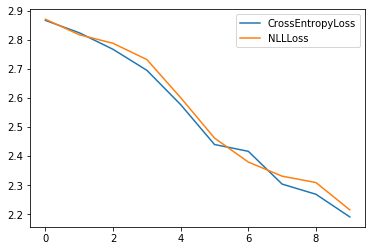

In [54]:
iters = 10000
print_each = iters / 5
plot_each = iters / 10

rnn1 = RNN(n_letters, n_hidden, n_categories)
rnn2 = RNN(n_letters, n_hidden, n_categories)
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.NLLLoss()

print(criterion1)
l1, tt1 = make_history(rnn1, n_iters = iters, pr_freq = print_each, pl_freq = plot_each, criterion = criterion1)
print(criterion2)
l2, tt2 = make_history(rnn2, n_iters = iters, pr_freq = print_each, pl_freq = plot_each, criterion = criterion2)

plt.plot(l1, label = 'CrossEntropyLoss')
plt.plot(l2, label = 'NLLLoss')
plt.legend()

CrossEntropyLoss()
GRU(
  (i2h): GRU(57, 128)
  (i2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax()
)
2000 20% (0m 7s) 2.8307 Keogh / Chinese ✗ (English)
4000 40% (0m 16s) 2.9024 Stolarz / Italian ✗ (Polish)
6000 60% (0m 24s) 2.8135 Chu / Vietnamese ✓
8000 80% (0m 32s) 2.7044 Maslanka / Polish ✓
10000 100% (0m 40s) 2.9210 Arian / Irish ✗ (Arabic)
NLLLoss()
GRU(
  (i2h): GRU(57, 128)
  (i2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax()
)
2000 20% (0m 8s) 2.9216 Busch / Russian ✗ (German)
4000 40% (0m 16s) 2.6720 Geng / Chinese ✓
6000 60% (0m 24s) 2.7347 Belo / Portuguese ✓
8000 80% (0m 32s) 2.7813 Tron / Vietnamese ✓
10000 100% (0m 40s) 2.6017 Sugiyama / Japanese ✓


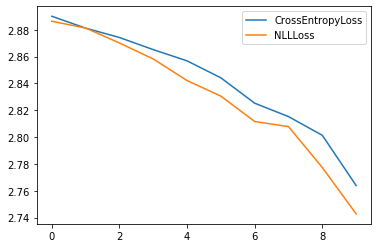

In [59]:
gru1 = GRU(n_letters, n_hidden, n_categories)
gru2 = GRU(n_letters, n_hidden, n_categories)
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.NLLLoss()

print(criterion1)
l3, tt3 = make_history(gru1, n_iters = iters, pr_freq = print_each, pl_freq = plot_each, criterion = criterion1)
print(criterion2)
l4, tt4 = make_history(gru2, n_iters = iters, pr_freq = print_each, pl_freq = plot_each, criterion = criterion2)

plt.plot(l3, label = 'CrossEntropyLoss')
plt.plot(l4, label = 'NLLLoss')
plt.legend()